<a href="https://colab.research.google.com/github/clint-bg/publicationdata/blob/main/safeSeparation/safeDistancesOpenBurnplus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heat Flux and Safe Distances from Propellants and Fireworks
***
## Approach: Estimate the safe distance from test data
This notebook summarizes over 750 heat flux experimental measurements by estimating the safe separation distance to prevent second degree burns. Clint Guymon
***
## Conclusions: 
- The safe separation distance is adequately captured by the existing US IBD HD1.3 siting distance for unconfined scenarios. 
- Confined versus Unconfined scenarios are vastly different in the calculated safe distances and violence of the reaction

***
## Necessary code and data import

In [1]:
#Import necessary packages
#%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sea; #sea.set_palette(sea.color_palette("Set2")) #"Paired" "cubehelix"
from scipy.optimize import fsolve, minimize
from scipy.stats import t #import t distribution methods

### Import data

The majority of the heat flux data is from "Scaling Studies of Thermal Radiation Flux from Burning Propellants" by J. Hay and R.W. Watson of Bureau of Mines as commissioned by the DDESB in 1992. Data from 14 other references of burning energetic material where the heat flux was measured is also summarized.

In [2]:
url = 'https://raw.githubusercontent.com/clint-bg/publicationdata/main/safeSeparation/heatfluxdataplus.csv' #url with raw data
df = pd.read_csv(url)

In [3]:
df.columns

Index(['Ref ID', 'Reference', 'Propellant Type', 'Test #', 'Mass (kg)',
       'Fireball or Plume Distance (m)', 'Measurement Distance (m)',
       'Burn Time (sec)', 'Peak Flux (cal/cm^2/s)', 'Av. Flux (cal/cm^2/s)',
       'Hazard: Source', 'Event Type', 'Drum Diameter (cm)', 'Configuration',
       'Notes'],
      dtype='object')

In [4]:
#add new column for unique id = ref id + test id
df['Unique ID'] = df.agg('R{0[Ref ID]}T{0[Test #]}'.format, axis=1)

## Data summary

In [5]:
summary = df.groupby('Ref ID')['Reference'].unique().to_frame()
summary['Propellant Types'] = df.groupby('Ref ID')['Propellant Type'].unique()
summary['# of Tests'] = df.groupby('Ref ID')['Unique ID'].nunique()
summary

,Reference,Propellant Types,# of Tests
Ref ID,,,
1,[Hay J. E. and Watson R. W. “Scaling Studies o...,"[IMR5010, M1-8-SP, M1-8-MP, WC844, WC846, WCBl...",49
10,"[Joachim C E ""M-1 Propellant Tests: Deflagrati...",[M1],3
11,[Farmer et al. “Combustion of Hazard Division ...,[M1],3
12,[Wilson W. Anderson J. and Meyden M. Titan IV ...,[Rocket Propellant],1
13,"[""Internal Video Footage of Titan Rocket Motor...",[Rocket Propellant],1
2,[Harmanny A. “Thermal Radiation Flux of Firewo...,[Fireworks],16
3,[Pape R. Waterman T. E. and Takata A. N. “Fire...,"[M1, WC844]",46
4,[Guymon C. G. “Heat Flux from the Top Ignition...,[WC814],1
5,[Bon A. “Convective Combustion of Unconfined H...,[M1],1


In [6]:
#References
for i,each in enumerate(set(df['Reference'])):
    print(i,":",each) 

0 : Hay J. E. and Watson R. W. “Scaling Studies of Thermal Radiation Flux From Burning Propellants” Defense Technical Information Center Vol. 1992-08-01 No. ADA527525 1992 pp. 233–268
1 : Allain L. “Combustion of Gun Propellant in Igloo Thermal Flux Measurements” US Army Corps of Engineers Vol. SNPE No. 153/91/-S/TS/NP 1991 in TM 8668 Page 300+
2 : Wilson W. Anderson J. and Meyden M. Titan IV SRMU PQM-1 Overview 28th Joint Propulsion Conference and Exhibit 2012. https://doi.org/10.2514/6.1992-3819
3 : Bon A. “Convective Combustion of Unconfined HD 1.3 Material in Fiber Barrels” China Lake Ranges Test Operation Branch(DB1110M) Unpublished Data 2020
4 : Paquet F. Ng H. D. Paquet M. Cottin F. and Groulx D. “Modeling propellant fires radiant heat flux” Journal of Energetic Materials Vol. 37 No. 1 2019 pp. 110–124. https://doi.org/10.1080/07370652.2018.1542468
5 : Harmanny A. “Thermal Radiation Flux of Fireworks” OECD-IGUS Report: Prins Maurits Laboratorium TNO 1992
6 : Lucotte, "Measuremen

In [7]:
#propellant types
set(df['Propellant Type'])

{'"hunting powder"',
 '20 mm powder',
 '35mm propellant',
 'Cordite',
 'DB1',
 'DB2',
 'Fireworks',
 'GP11',
 'IMR5010',
 'LB 7 T 72 (0,8) (Similar to M1)',
 'M1',
 'M1-8-MP',
 'M1-8-SP',
 'MTV',
 'Rocket Propellant',
 'SB1',
 'SB2',
 'WC814',
 'WC844',
 'WC846',
 'WCBlank',
 'di-tert-butyl peroxide'}

In [8]:
#number of tests for each propellant
df.groupby('Propellant Type')['Unique ID'].nunique(), df.groupby('Propellant Type')['Unique ID'].nunique().sum()

(Propellant Type
 "hunting powder"                    1
 20 mm powder                        6
 35mm propellant                    15
 Cordite                             8
 DB1                                 4
 DB2                                 2
 Fireworks                          16
 GP11                                2
 IMR5010                            13
 LB 7 T 72 (0,8) (Similar to M1)     2
 M1                                 34
 M1-8-MP                            12
 M1-8-SP                            14
 MTV                                12
 Rocket Propellant                   2
 SB1                                 5
 SB2                                 5
 WC814                               1
 WC844                              27
 WC846                               3
 WCBlank                             3
 di-tert-butyl peroxide              3
 Name: Unique ID, dtype: int64, 190)

In [9]:
#total number of heat flux measurements
len(df)

777

In [10]:
df.describe() #summary statistics for numerical data

,Mass (kg),Fireball or Plume Distance (m),Measurement Distance (m),Burn Time (sec),Peak Flux (cal/cm^2/s),Av. Flux (cal/cm^2/s),Drum Diameter (cm)
count,777.000000,20.000000,777.000000,741.000000,757.000000,777.000000,154.000000
mean,879.750824,36.585000,8.740412,27.760999,3.972361,1.555819,59.376623
std,11611.806873,24.296681,8.526432,30.156340,8.207214,3.070879,3.829841
min,0.100000,5.000000,0.400000,0.400000,0.001505,0.000000,36.000000
25%,25.000000,26.000000,3.000000,5.400000,0.173683,0.074000,60.000000
50%,50.000000,40.000000,6.000000,17.000000,0.570000,0.240000,60.000000
75%,136.400000,40.000000,12.000000,42.000000,2.919840,1.400000,60.000000
max,314158.000000,126.000000,126.000000,215.000000,65.553588,24.737203,60.000000


In [11]:
df.head(3) #first 3 rows of the data frame

,Ref ID,Reference,Propellant Type,Test #,Mass (kg),Fireball or Plume Distance (m),Measurement Distance (m),Burn Time (sec),Peak Flux (cal/cm^2/s),Av. Flux (cal/cm^2/s),Hazard: Source,Event Type,Drum Diameter (cm),Configuration,Notes,Unique ID
0,1,Hay J. E. and Watson R. W. “Scaling Studies of...,IMR5010,1,45.4,NaN,8.0,35.0,0.468,0.127,Heat Flux: Test Data,Unconfined,60.0,NaN,Barrel,R1T1
1,1,Hay J. E. and Watson R. W. “Scaling Studies of...,IMR5010,1,45.4,NaN,6.4,35.0,0.576,0.161,Heat Flux: Test Data,Unconfined,60.0,NaN,Barrel,R1T1
2,1,Hay J. E. and Watson R. W. “Scaling Studies of...,IMR5010,1,45.4,NaN,5.0,35.0,1.068,0.289,Heat Flux: Test Data,Unconfined,60.0,NaN,Barrel,R1T1


## Plot of the Safe Heat Flux vs. Exposure Time

Safe heat flux is per 6055.09, 2012, V1.E9.3.1.2 to prevent second degree burns. with the included limit that after a duration of 20 seconds, the allowable heat flux remains constant with increasing exposure time. 

In [12]:
#define a safe heat flux as a function of distance per second degree burns and a max exposure time of 20 seconds
#(per 6055.09, 2012, V1.E9.3.1.2 to prevent second degree burns)
qsafeat20 = 0.116 #qsafe at 20 second exposure
def safeHF(t):
    return (t/0.858)**(-1/1.46) if t<20 else qsafeat20

In [13]:
#add column for safe heat flux 
safeQ = df.groupby('Unique ID').apply(lambda x: np.percentile(
    [safeHF(x) for x in x['Burn Time (sec)']],75))
safeQ.name = 'Safe Heat Flux (cal/cm2/sec)'
#add to dataframe
df['Safe Heat Flux (cal/cm2/sec)'] = df['Unique ID'].apply(lambda x:safeQ.loc[x])

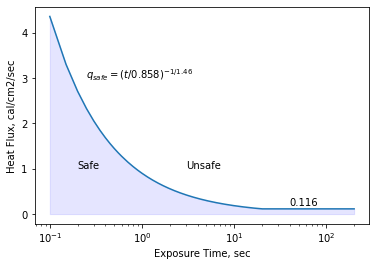

In [14]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
x = np.arange(.1,200,0.05); y=[safeHF(x) for x in x]; 
ax.set_xscale('log');
plt.plot(x,y);
ax.fill_between(x,y,color="blue", alpha=0.1)
plt.text(0.2, 1, 'Safe');plt.text(3, 1, 'Unsafe');plt.text(40, 0.2, '0.116') #, bbox=dict(facecolor='red', alpha=0.5))
plt.text(.25,3,'$q_{safe}=(t/0.858)^{-1/1.46}$')
plt.xlabel('Exposure Time, sec');plt.ylabel('Heat Flux, cal/cm2/sec')
plt.show(block=False)

Here, burn time is equated to the exposure time. After 20 seconds the allowed heat flux is constant at 0.116 cal/cm2/s

### Calculate a safe distance based on the point source model

Calculate a safe distance based on the average heat flux. The average heat flux is used instead of the peak heat flux as the peak heat flux is a short term event and is a small fraction of the total burn typically. The parameters of a Point Source Model are found according to the following where $r^2$ is the squared distance from the center of the fire: 
\begin{equation}
q = \frac{\alpha}{r^2} \\
\end{equation}

In [15]:
#completed for each test (unique id)
alphas = df.groupby('Unique ID').apply(lambda x: np.percentile(
    x['Av. Flux (cal/cm^2/s)']*x['Measurement Distance (m)']**2,75))
#alphas = [1 if each < 1 else each for each in alphas]
safeDistance = np.sqrt(alphas/safeQ)
safeDistance = pd.Series(safeDistance)
safeDistance.name = 'Safe Distance (m)'
safeDistance.index = safeQ.index

In [16]:
#add column for safe distance
df['Safe Distance (m)'] =  df['Unique ID'].apply(lambda x:safeDistance.loc[x])
#add column for burn rate
burnRate = df.groupby('Unique ID').apply(lambda x: np.percentile(x['Mass (kg)']/x['Burn Time (sec)'],50))
burnRate.name = 'Burn rate (kg/s)'
df['Burn Rate (kg/s)'] =  df['Unique ID'].apply(lambda x:burnRate.loc[x])

In [17]:
safeDistance = pd.DataFrame(safeDistance)
safeDistance['Propellant Type'] = df.groupby('Unique ID').apply(lambda x: x['Propellant Type'].iloc[0])
safeDistance['Mass (kg)'] = df.groupby('Unique ID').apply(lambda x: x['Mass (kg)'].iloc[0])
safeDistance['Safe Heat Flux (cal/cm2/sec)'] = df.groupby('Unique ID').apply(lambda x: x['Safe Heat Flux (cal/cm2/sec)'].iloc[0])
safeDistance['alphas'] = alphas

In [18]:
safeDistance[safeDistance['Propellant Type']=='M1-8-MP']

,Safe Distance (m),Propellant Type,Mass (kg),Safe Heat Flux (cal/cm2/sec),alphas
Unique ID,,,,,
R1T12,7.974583,M1-8-MP,47.6,0.199918,12.71360
R1T16,11.077484,M1-8-MP,47.6,0.155406,19.07000
R1T17,9.998706,M1-8-MP,47.6,0.164164,16.41216
R1T24,14.137273,M1-8-MP,95.3,0.140897,28.16000
R1T25,14.661709,M1-8-MP,95.3,0.140897,30.28800
R1T3,8.683471,M1-8-MP,47.6,0.140897,10.62400
R1T30,15.398794,M1-8-MP,190.5,0.116000,27.50625
R1T33,10.339499,M1-8-MP,47.6,0.164164,17.55000
R1T36,15.425773,M1-8-MP,142.9,0.117722,28.01250


In [19]:
#example analysis result for Safe Distance given test results
df[df['Unique ID']=='RMSIAC 6TC4']#['Av. flux (cal/cm^2/s)']

,Ref ID,Reference,Propellant Type,Test #,Mass (kg),Fireball or Plume Distance (m),Measurement Distance (m),Burn Time (sec),Peak Flux (cal/cm^2/s),Av. Flux (cal/cm^2/s),Hazard: Source,Event Type,Drum Diameter (cm),Configuration,Notes,Unique ID,Safe Heat Flux (cal/cm2/sec),Safe Distance (m),Burn Rate (kg/s)
686,MSIAC 6,Paquet F. Ng H. D. Paquet M. Cottin F. and Gro...,DB1,C4,525.0,NaN,20.0,7.1,1.105804,0.552902,Heat Flux: Test Data,Unconfined,NaN,NaN,Durations not provided; estimated using equati...,RMSIAC 6TC4,0.235174,34.445076,73.943662
687,MSIAC 6,Paquet F. Ng H. D. Paquet M. Cottin F. and Gro...,DB1,C4,525.0,NaN,16.0,7.1,2.631956,1.315978,Heat Flux: Test Data,Unconfined,NaN,NaN,Durations not provided; estimated using equati...,RMSIAC 6TC4,0.235174,34.445076,73.943662
688,MSIAC 6,Paquet F. Ng H. D. Paquet M. Cottin F. and Gro...,DB1,C4,525.0,NaN,8.0,7.1,5.201815,2.600908,Heat Flux: Test Data,Unconfined,NaN,NaN,Durations not provided; estimated using equati...,RMSIAC 6TC4,0.235174,34.445076,73.943662


## Add modeling results from COMSOL with Radiation in Participating Media
COMSOL modeling was completed with a representative barrel of burning material at a given burn rate and temperature with radiative propagation from the hot gases.

In [20]:
url='https://raw.githubusercontent.com/clint-bg/publicationdata/main/safeSeparation/COMSOLModeling.csv'
dfm = pd.read_csv(url)
dft = pd.concat([df,dfm])

Note that there are many different ways that a safe distance could be estimated. The method used here is viewed by the authors as a conservative estimate. In previous plots, a modified version of the point source model with a 1/r dependence transitioning to a 1/r^2 dependence was used yielding slightly different results but with the same conclusion that the existing IBD line is effective in specifying a safe distance.

In [21]:
#Add additional lines
mlin = np.linspace(1,1000000,num=100000)
ibd = [max(22.9,np.exp(1.4715+0.2429*np.log(each)+0.00384*(np.log(each))**2)) if each<43544 else (np.exp(5.5938-0.5344*np.log(each)+0.04046*(np.log(each))**2) if each<453590 else 3.17*each**0.333) for each in mlin]
ibddf = pd.DataFrame({'masses (kg)':mlin,'ibd (m)':ibd})
natoibddf = pd.DataFrame({'NEQ (kg)':[1,	5,	10,	50,	100,	453,	500,	800,	1000,	5000,	10000,	43544,	500000,	1000000],'ibd (m)':[60,	60,	60,	60,	60,	60,	60,	60,	64,	109,	137,	225,	507,	640]})
DESR80df = pd.DataFrame({'NEQ (kg)':[1,10,50,100,150],'SafeD (m)':[3.22,7.97,15.0,19.7,22.9]})

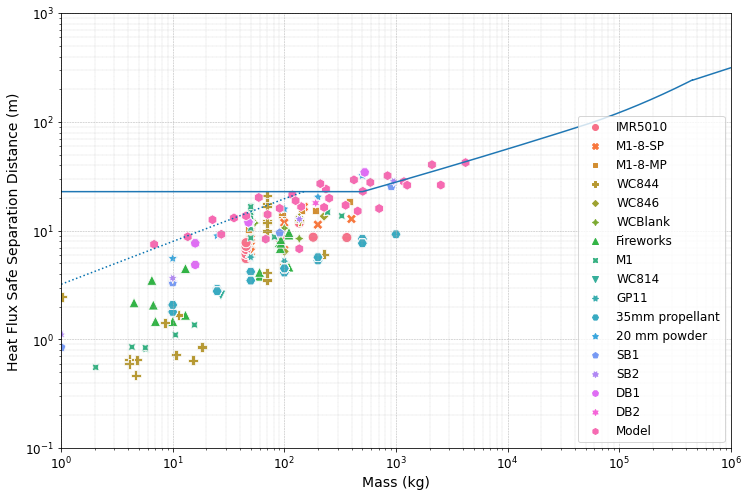

In [22]:
#Plot a subset: unconfined burn data
fig, ax = plt.subplots(figsize=(12,8))
p = sea.scatterplot(data=dft[(dft['Event Type']=='Unconfined')],x='Mass (kg)',y='Safe Distance (m)', hue='Propellant Type', style='Propellant Type',s=100,ax=ax);
p = sea.lineplot(data=ibddf,x='masses (kg)',y='ibd (m)',ax=ax)
#p = sea.lineplot(data=DESR80,x='NEQ (kg)',y='SafeD (m)',ax=ax)
plt.plot(DESR80df['NEQ (kg)'],DESR80df['SafeD (m)'],color='#0270AF',linestyle=':')
p.set(xscale="log"); p.set(xlim=(1,1000000))
p.set(yscale="log"); p.set(ylim=(0.1,1000))
plt.legend(loc='lower right', fontsize=12)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.grid(visible=True,which='minor',linestyle = '--', linewidth = 0.25)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Mass (kg)', fontsize=14)
ax.set_ylabel('Heat Flux Safe Separation Distance (m)', fontsize=14)
plt.savefig("SafeSepDistsU.png",dpi=600)
plt.show()

In [29]:
dft[(dft['Safe Distance (m)']>30) & (dft['Propellant Type']=='20 mm powder')]['Notes'].iloc[0]

'Flux density determined using 2mm thick blackened aluminium plates. Max temperature was determined using irreversible temperature indicators; flux density then calculated using heat capacity of plates and tempreature differential. In addition, the temperature curve was recorded with the aid of an infrared radiometer. No duration values given: assume t=0.25Q^0.25'

In [30]:
dft[(dft['Safe Distance (m)']>30) & (dft['Propellant Type']=='DB1')]['Notes'].iloc[0]

'Durations not provided; estimated using equation provided in paper 3.225Q^0.126; Ave heat flux is estimated from the peak heat flux/2'

## Add in Confined Scenarios with Debris Distance (1/600) Estimates
The 1/600 reference to the DESR 6055.09 criteria of one hazardous fragment per 600 square feet.

In [23]:
url='https://raw.githubusercontent.com/clint-bg/publicationdata/main/safeSeparation/ConfinedDebrisSafeDistances.csv'
dfd = pd.read_csv(url)
dfd['Safe Distance (m)'] = dfd['HFD (m)']
dfa = pd.concat([dft,dfd])

In [24]:
#Add in proposed lines and HD 1.2.2
onetwotwo = [max(30.5,28.127-2.364*np.log(each)+1.577*np.log(each)**2) for each in mlin]
newOneThree =  [min(3.216*each**0.3939,ibd[i]) for i,each in enumerate(mlin)]
onetwotwodf = pd.DataFrame({'masses (kg)':mlin,'ibd (m)':onetwotwo})
newOneThreedf = pd.DataFrame({'masses (kg)':mlin,'newibd (m)':newOneThree})
newConf = [onetwotwo[i] if each<1E4 else 6.4*each**0.333 for i,each in enumerate(mlin)]
newConfdf = pd.DataFrame({'masses (kg)':mlin,'ibd (m)':newConf})

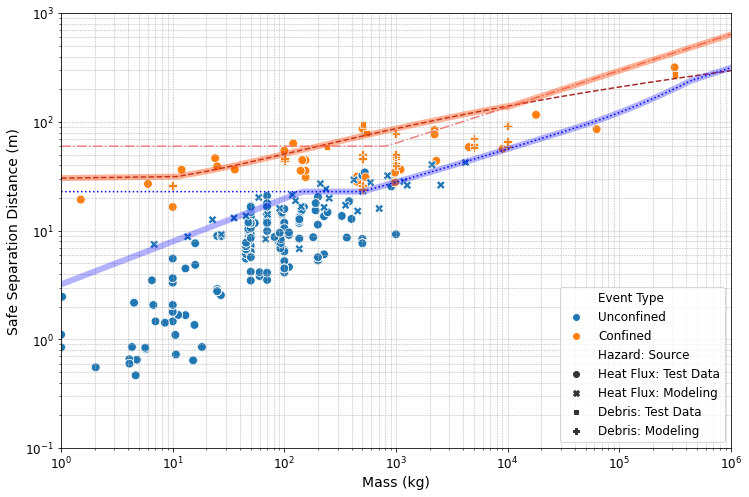

In [25]:
fig, ax = plt.subplots(figsize=(12,8))
p = sea.scatterplot(data=dfa,x='Mass (kg)',y='Safe Distance (m)', style='Hazard: Source', hue='Event Type', s=75,ax=ax);
p = sea.lineplot(data=ibddf,x='masses (kg)',y='ibd (m)',linestyle=':',color='b',ax=ax)
p = sea.lineplot(data=onetwotwodf,x='masses (kg)',y='ibd (m)',linestyle='--',color='brown',ax=ax)
p = sea.lineplot(data=natoibddf,x='NEQ (kg)',y='ibd (m)',linestyle='-.',color='lightcoral',ax=ax)
p = sea.lineplot(data=newOneThreedf,x='masses (kg)',y='newibd (m)',color='b',alpha=0.3, linewidth = 6,ax=ax)
p = sea.lineplot(data=newConfdf,x='masses (kg)',y='ibd (m)',color='orangered',alpha=0.4, linewidth = 6,ax=ax)
#plt.plot(dfd['Mass (kg)'],dfd['HFD (m)'],color='g',marker='x',s=100,label='Hello')
p.set(xscale="log"); p.set(xlim=(1,1000000))
p.set(yscale="log"); p.set(ylim=(0.1,1000))
plt.legend(loc='best', fontsize=12)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.grid(visible=True,which='minor',linestyle = '--', linewidth = 0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Mass (kg)', fontsize=14)
ax.set_ylabel('Safe Separation Distance (m)', fontsize=14)
plt.savefig("SafeSepDists.png",dpi=600)
plt.show()

In [26]:
sumdf = dfa.groupby('Reference')['Ref ID'].unique().to_frame()
sumdf['Propellant Types'] = dfa.groupby('Reference')['Propellant Type'].unique()
sumdf['# of Tests'] = dfa.groupby('Reference')['Unique ID'].nunique()
sumdf['Total # of Heat Flux Measurements']=dfa.groupby('Reference')['Av. Flux (cal/cm^2/s)'].count()
sumdf['Event Types']=dfa.groupby('Reference')['Event Type'].unique()
sumdf.to_csv('out.csv')
sumdf

,Ref ID,Propellant Types,# of Tests,Total # of Heat Flux Measurements,Event Types
Reference,,,,,
"""Internal Video Footage of Titan Rocket Motor Ignition after Crane Failure” Safety Management Services Inc. 1990.",[13],[Rocket Propellant],1,1,[Confined]
Allain L. “Combustion of Gun Propellant in Igloo Thermal Flux Measurements” US Army Corps of Engineers Vol. SNPE No. 153/91/-S/TS/NP 1991 in TM 8668 Page 300+,[9],"[LB 7 T 72 (0,8) (Similar to M1)]",2,12,[Confined]
Blankenhagel P. Wehrstedt K.-D. Mishra K. B. and Steinbach J. “Thermal radiation assessment of fireballs using infrared camera” Journal of Loss Prevention in the Process Industries Vol. 54 2018 pp. 246–253. https://doi.org/10.1016/j.jlp.2018.04.008,[7],[di-tert-butyl peroxide],3,9,[Confined]
Bon A. “Convective Combustion of Unconfined HD 1.3 Material in Fiber Barrels” China Lake Ranges Test Operation Branch(DB1110M) Unpublished Data 2020,[5],[M1],1,4,[Unconfined]
Bon A. “Convective Combustion of a Hazard Division 1.3 M1 Gun Propellant in Fiber Barrels Heat Flux Data” China Lake Ranges Test Operation Branch Unpublished Data 2020,[6],[M1],2,7,[Unconfined]
Bon A. “M1 Propellant Testing Inside an ISO Container” China Lake Ranges Test Operation Branch Unpublished Data 2020,[China Lake 1],[M1],2,16,[Confined]
Farmer et al. “Combustion of Hazard Division 1.3 M1 Gun Propellant in a Reinforced Concrete Structure” Defense Technical Information Center Vol. NAWCWD TM8742 No. ADA622373 2015,"[11, 1]",[M1],3,3,[Confined]
Guymon C. G. “Heat Flux from the Top Ignition of a Single Barrel of WC814” Safety Management Services Inc. Unpublished Data 2020,[4],[WC814],1,4,[Unconfined]
Guymon C. G. “Integrated Violence Model (IVM) of 1.3 Events” 2018 NDIA Conference 2018.,[7],[nan],0,0,[Confined]
